## Shifted calendars 
In s2s forecasting modelling we often use a calendar type that 'rolls' forward over time.

For example, we wish to forecast temperature for every week of June and July with a two 
week leadtime, keeping that leadtime constant. 

This imitates an NWP model weather forecast that is initiated every week.

Another example could be that we wish to investigate the influence of intraseasonal 
variability of one of our precursors over time.

With `s2spy.calendar_shifter`, the user can easily create calendars that suit these needs.
This notebook shows how to:
  * Shift a calendar n number of times (desired number of 'runs') and return a list of 
    those calendars
  * Resample a dataset to those calendars resulting in an `xarray.Dataset`
    with new dimension 'run'

Note that the anchor year for every target period is kept the same relative to the first
calendar. Even if a target period is shifted to the next year, the anchor year of the 
target period stays the same.

In [13]:
import s2spy.calendar_shifter
import matplotlib.pyplot as plt
import numpy as np

Let's initiate a calendar with the following characteristics:
  * starting on July 1st
  * 1 target period with 7 days length
  * 4 precursor periods of 7 days length
  * 14 days leadtime

(this will change after add_intervals gets keyword argument 'n')

In [2]:
cal = s2spy.time.Calendar(anchor='07-01')
cal.add_interval("target", "7d")
cal.add_interval("precursor", "7d", gap="14d")
for _ in range(3):
    cal.add_interval("precursor", "7d")
#cal.add_intervals("target", "7d")
#cal.add_intervals("precursor", "7d", gap="14d")
#cal.add_intervals("precursor", "7d", n=3)
cal

Calendar(
    anchor='07-01',
    allow_overlap=False,
    mapping=None,
    intervals=[
        Interval(role='target', length='7d', gap='0d'),
        Interval(role='precursor', length='7d', gap='14d'),
        Interval(role='precursor', length='7d', gap='0d'),
        Interval(role='precursor', length='7d', gap='0d'),
        Interval(role='precursor', length='7d', gap='0d')
    ]
)

Then we build up a list of calendars. We shift (using `s2spy.calendar_shifter.cal_shifter`) the initial calendar by 7 days three times such that we get four 'runs':

(note that the anchor date does not change, only the gaps relative to the anchor date change)

In [4]:
cal_list =  s2spy.calendar_shifter.staggered_calendar(cal, shift='7d', n_shifts=3)
cal_list

[Calendar(
     anchor='07-01',
     allow_overlap=False,
     mapping=None,
     intervals=[
         Interval(role='target', length='7d', gap='0d'),
         Interval(role='precursor', length='7d', gap='14d'),
         Interval(role='precursor', length='7d', gap='0d'),
         Interval(role='precursor', length='7d', gap='0d'),
         Interval(role='precursor', length='7d', gap='0d')
     ]
 ),
 Calendar(
     anchor='07-01',
     allow_overlap=False,
     mapping=None,
     intervals=[
         Interval(role='target', length='7d', gap={'days': 7}),
         Interval(role='precursor', length='7d', gap={'days': 7}),
         Interval(role='precursor', length='7d', gap='0d'),
         Interval(role='precursor', length='7d', gap='0d'),
         Interval(role='precursor', length='7d', gap='0d')
     ]
 ),
 Calendar(
     anchor='07-01',
     allow_overlap=False,
     mapping=None,
     intervals=[
         Interval(role='target', length='7d', gap={'days': 14}),
         Interval(role='

We map all the calendars to some year (2021) before visualizing:

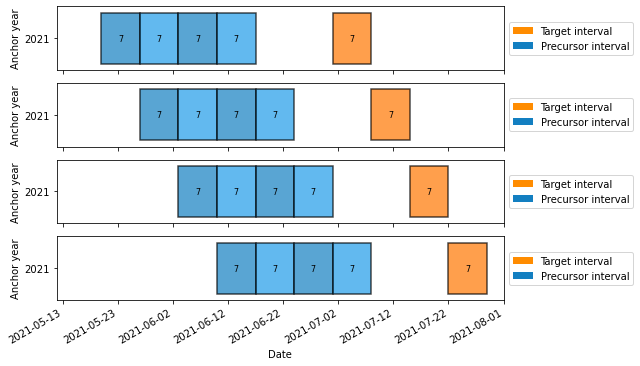

In [17]:
for cal in cal_list:
    cal.map_years(2021,2021)
    
fig, axes = plt.subplots(nrows=len(cal_list), sharex=True, figsize=(8,6))
for i, cal in enumerate(cal_list):
    cal.visualize(n_years=1, relative_dates=False, show_length=True, ax=axes[i])
axes[-1].set_xlim([np.datetime64("2021-05-12"), np.datetime64("2021-08-01")])
fig.autofmt_xdate()

Before resampling, we make a dummy dataset:

In [6]:
import xarray as xr
import numpy as np
import pandas as pd

time_index = pd.date_range('20160101', '20211231', freq='1d')

np.random.seed(0)
temperature = 15 + 8 * np.random.randn(2, 2, len(time_index))
precipitation = 10 * np.random.rand(2, 2, len(time_index))

lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]


ds = xr.Dataset(
    data_vars=dict(
        temperature=(["x", "y", "time"], temperature),
        precipitation=(["x", "y", "time"], precipitation),
    ),
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
        time=time_index,
    ),
    attrs=dict(description="Weather related data."),
)
ds

<xarray.Dataset>
Dimensions:        (x: 2, y: 2, time: 2192)
Coordinates:
    lon            (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat            (x, y) float64 42.25 42.21 42.63 42.59
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2021-12-31
Dimensions without coordinates: x, y
Data variables:
    temperature    (x, y, time) float64 29.11 18.2 22.83 ... 12.88 18.37 6.114
    precipitation  (x, y, time) float64 3.959 0.6514 7.969 ... 6.654 0.1702
Attributes:
    description:  Weather related data.

Resample by using the `s2spy.calendar_shifter.cal_list_resampler` function.

Before we resample, it is important to map our calendar to the desired years. Before, we mapped it to the year
it to 2021. Now, we can set it to other years using:

```py
for cal in cal_list:
    cal.map_years(2018,2021)
```

or we use the cal.map_to_data function to map our calendar to the dummy dataset:

```py
for cal in cal_list:
    cal.map_to_data(ds)
```

We will resample to data.

In [9]:
for cal in cal_list:
    cal.map_to_data(ds)

In [10]:
ds_r = s2spy.calendar_shifter.cal_list_resampler(cal_list, ds)
ds_r

<xarray.Dataset>
Dimensions:        (anchor_year: 6, i_interval: 5, x: 2, y: 2, run: 4, bounds: 2)
Coordinates:
  * anchor_year    (anchor_year) int64 2021 2020 2019 2018 2017 2016
  * i_interval     (i_interval) int64 -4 -3 -2 -1 1
  * x              (x) int64 0 1
  * y              (y) int64 0 1
    interval       (run, anchor_year, i_interval, bounds) datetime64[ns] 2021...
    target         (i_interval) bool False False False False True
  * run            (run) int64 0 1 2 3
Dimensions without coordinates: bounds
Data variables:
    temperature    (run, anchor_year, i_interval, x, y) float64 16.88 ... 14.19
    precipitation  (run, anchor_year, i_interval, x, y) float64 3.663 ... 4.761